In [1]:
from collections import OrderedDict # sortare lista
from collections import Counter

from nltk.corpus import wordnet # pentru eliminare stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from gensim.parsing.preprocessing import remove_stopwords
import gensim.models as g

import itertools # pentru sortare
import numpy as np
import pandas as pd
import re
import string # punctiatie si lower

import matplotlib.pyplot as plt # vizualizare dendograma
import matplotlib.cm as cm

In [2]:
def elimina_punctuatia(list_fos):
    new_list_fos = []
    
    for fos in list_fos:
        
        word = ""
        new_current_fos = []
        fos = fos.lower()
        for ch in fos:
            if ch == ' ' or ch =='-':
                word = re.sub(r'\d+', '', word)
                new_current_fos.append(word)
                word = ""
            else:
                if ch not in string.punctuation:
                    word += ch
                    
        word = re.sub(r'\d+', '', word)
        new_current_fos.append(word)
        new_list_fos.append(new_current_fos)
        
    return new_list_fos

def elimina_stopwords(fos_l):
    new_fos_l = []
    for fos in fos_l:
        new_fos = []
        for elem in fos:
            if elem not in gensim.parsing.preprocessing.STOPWORDS and len(elem) > 2:
                new_fos.append(elem)
        new_fos_l.append(new_fos)
    return new_fos_l

def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

def lemmatize_word(word, pos):
    wnl = WordNetLemmatizer()
    return (wnl.lemmatize( word, pos ))
    

def get_abstr(fileName):
    r = open(fileName,'r')
    abstr_list = []
    for line in r:
        abstr_list.append(remove_stopwords(line))
    new_a = []
    new_a = elimina_punctuatia(abstr_list)
    abstr_final = []
    for doc in new_a:
        crt_final = []
        for word in doc:
            l_word = lemmatize_word(word, get_pos(word))
            if len(l_word) > 2 :
                crt_final.append(l_word)
        abstr_final.append(crt_final)
            
    return abstr_final

In [7]:
abstr_list = get_abstr('test_abstracts.txt')
print(len(abstr_list))
print(abstr_list[0])

10
['probabilistic', 'latent', 'semantic', 'analysis', 'statistical', 'information', 'retrieval', 'filter', 'natural', 'language', 'process', 'machine', 'learn', 'text', 'latent', 'semantic', 'analysis', 'stem', 'linear', 'algebra', 'singular', 'value', 'decompositio', 'decomposition', 'latent', 'class', 'statistic', 'overfitting', 'maximum', 'likelihood', 'fit', 'latent', 'semantic', 'analysis']


In [8]:
model="./enwiki_dbow/doc2vec.bin"

#inference hyper-parameters
start_alpha=0.01
infer_epoch=1000

#load model
m = g.Doc2Vec.load(model)

In [9]:
def apply_doc2vec(doc_list):
    X = []
    for doc in doc_list:
        inferred_vector = m.infer_vector(doc, alpha=start_alpha, steps=infer_epoch)
        X.append(inferred_vector)
    return X

X = np.array(apply_doc2vec(abstr_list))
print(X)

[[-1.1954707e-02  7.4102730e-02 -3.9854524e-01 ... -1.5058911e-01
  -3.0493987e-01 -3.3841735e-01]
 [ 2.6006240e-01 -2.0373161e-01  4.1929367e-01 ...  4.0519664e-01
  -8.3633745e-01 -5.0765852e-04]
 [ 2.6066136e-01  2.5904894e-01  4.4886291e-02 ...  1.1243383e-01
  -1.0701528e-01 -3.9771119e-01]
 ...
 [ 6.1985075e-01  4.8229462e-01 -2.5388192e-02 ...  7.4257028e-01
  -2.3535995e-01 -4.1195132e-02]
 [ 4.2059743e-01  1.0789683e-01 -2.5253338e-01 ...  7.2103685e-01
  -4.5209017e-01 -2.8315881e-01]
 [-3.9084926e-01  3.9064360e-01  2.1498117e-01 ...  8.0115038e-01
  -7.9303497e-01 -1.1569611e+00]]


For n_clusters = 2 The average silhouette_score is : 0.1159292


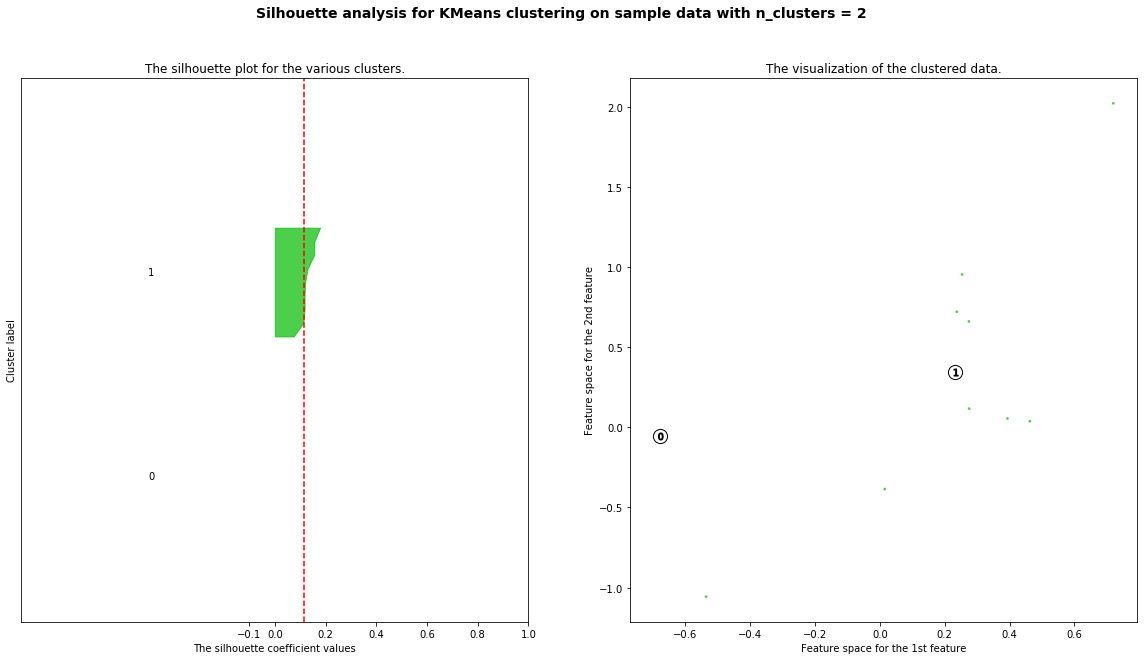

In [31]:
for n_clusters in range(2,3):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.5, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [10]:
pca = PCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X))
print(transformed)

          0         1
0  1.474426  0.556627
1  1.587197 -2.934107
2  2.227786 -0.235187
3  4.737298  1.443100
4  3.590689  0.850853
5 -3.026385 -2.345180
6 -2.342462 -0.687861
7 -2.438790 -2.119167
8 -2.326876 -0.305890
9 -3.482884  5.776812


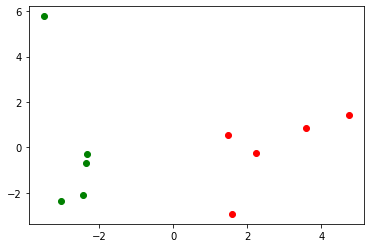

In [12]:
result_doc2vec = [[1.474426,0.556627],[1.587197,-2.934107],[2.227786,-0.235187],[4.737298, 1.443100],[3.590689, 0.850853],
                  [-3.026385,-2.345180],[-2.342462,-0.687861],[-2.438790,-2.119167],[-2.326876,-0.305890],
                  [-3.482884,5.776812]]
plt.plot([result_doc2vec[0][0], result_doc2vec[1][0],result_doc2vec[2][0],result_doc2vec[3][0],result_doc2vec[4][0]], 
         [result_doc2vec[0][1], result_doc2vec[1][1],result_doc2vec[2][1],result_doc2vec[3][1],result_doc2vec[4][1]],
         'ro',c="red")
plt.plot([result_doc2vec[5][0], result_doc2vec[6][0],result_doc2vec[7][0],result_doc2vec[8][0],result_doc2vec[9][0]], 
         [result_doc2vec[5][1], result_doc2vec[6][1],result_doc2vec[7][1],result_doc2vec[8][1],result_doc2vec[9][1]],
         'ro',c="green")
plt.show()

In [14]:
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels = clusterer.fit_predict(X)
print(cluster_labels)

[0 0 0 0 0 1 1 1 1 1]


# WORD2VEC

In [48]:
def create_model(all_abstr):
    model_dict = []
    for abstr in all_abstr:
        model_dict.append(abstr)
    model = g.Word2Vec(model_dict, size=20, window=1, min_count=1, iter=20)
    return  model
w2v_model = create_model(abstr_list)

In [62]:
def apply_word2vec(abstr_list,w2v_model):
    X = []
    for abstr in abstr_list:
        crt_X = []
        for word in abstr:
            crt_X.append(w2v_model.wv.__getitem__(word))
        X.append(crt_X)
    X = np.array(X)
    X_med = []
    for arrays in X:
        crt_len = len(arrays)
        med = np.zeros(crt_len)
        i = 0
        for ar in arrays:
            for elem in ar:
                med[i] += elem
            med[i] /= crt_len
            X_med.append(med)
            i += 1
        
    return X_med
X_w2v = apply_word2vec(abstr_list, w2v_model)

In [63]:
print(X_w2v)

[array([-1.40857356e-03, -1.01195002e-03,  9.74927295e-04, -1.41704241e-03,
        2.14516409e-04, -7.63325251e-04,  1.52522070e-03, -1.41704241e-03,
        1.07457054e-03, -2.77393925e-04, -1.63748074e-04, -1.15115002e-03,
        3.05706348e-04,  1.90477374e-04, -1.05503940e-03, -2.00490328e-04,
        1.22314941e-03,  5.43761111e-04, -1.22477350e-03, -4.83531024e-04,
       -4.76919423e-04, -5.24566292e-04, -4.82143343e-04, -5.62737560e-04,
       -6.85497707e-04, -1.77794951e-04, -1.01195002e-03,  9.74927295e-04,
       -1.41704241e-03,  5.84053663e-05,  6.07301167e-04, -1.04855146e-03,
       -6.35086659e-05,  1.40477623e-04, -3.50600580e-04,  1.06061685e-04,
       -1.63748074e-04,  1.85802313e-03,  5.49703202e-04, -1.99224813e-04,
       -6.69998230e-04, -1.01046989e-03,  1.06061685e-04,  2.26875787e-04,
       -1.01195002e-03,  1.06022419e-03,  7.12152042e-04,  1.28146457e-03,
        2.43227533e-04, -5.73842009e-04,  3.96254856e-04,  7.74688773e-04,
        4.06750011e-04, 